In [1]:
import pickle
import matplotlib
import matplotlib.gridspec as gridspec
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

from tqdm import tqdm
location = '/Users/perudornellas/python/imperial/cx1_am_kit/multiscale_tests/'
import os

In [2]:
matplotlib.rcParams.update({'font.size': 11, 
            'text.usetex': True, 'font.family': 'serif', 'font.serif': ['Computer Modern']})
matplotlib.rcParams.update({"axes.linewidth": 1})

In [3]:
lattice_files = [f for f in os.listdir(f'{location}results/lattices') if not f.startswith('.')]
property_files = [f for f in os.listdir(f'{location}results/properties') if not f.startswith('.')]
lattice_files.sort(); property_files.sort()
# print(property_files)



n_systems = len(lattice_files)
print(n_systems)
params_file = '/Users/perudornellas/python/imperial/cx1_am_kit/multiscale_tests/run_params.pickle'

with open(params_file, 'rb') as f:
    plaquette_numbers = pickle.load(f)
    minimum_L, maximum_L , n_steps = pickle.load(f)


# restrict to a subset for testing - comment out for proper runs
# lim = 50
# lattice_files = lattice_files[:lim]
# property_files= property_files[:lim]
# n_systems = len(lattice_files)

# iterate over all the systems

all_energies = np.zeros([n_systems, n_steps])
all_gaps = np.zeros([n_systems, n_steps])
all_gap_diff = np.zeros([n_systems, n_steps])
all_participations = np.zeros([n_systems, n_steps])
all_phase_differences = np.zeros([n_systems, n_steps])

for u, names in enumerate(zip(lattice_files, property_files)):
    f_name, p_name = names
    # print(f_name, p_name)
    assert(f_name[1] == p_name[1])
    
    # open the relevant file
    gaps = np.zeros([n_steps, 4])   # gap size for each sector of toric space
    gap_differences = np.zeros(n_steps)     # difference between the gap size of the smallest and largest toric sector  
    energies = np.zeros(n_steps)    # energy of the system per site
    participations = np.zeros([n_steps])    # p ratio of the lowest energy state
    phase_differences = np.zeros([n_steps])
    
    with open(location + 'results/lattices/' + f_name , 'rb') as f_lat, open(location + 'results/properties/' + p_name , 'rb') as f_res:
        for n in range(n_steps):
            # get energies over k space and participation ratios
            e_values, p_ratios, _ = pickle.load(f_res) 
            
            # find only the toric code sectors of energies
            indices = [0 , 10, 0 , 10] , [0 , 0 ,10 , 10]
            e_toric = e_values[ indices ]

            energies[n] = np.sum(np.abs(e_toric))/(4*e_values.shape[2])
            
            phase_energies = np.average(np.abs(e_values))
            phase_differences[n] = energies[n] - phase_energies 

            # print(phase_energies, energies[n])
            
            phase_gaps = np.min(np.abs(e_values), axis=1)

            gaps[n] = np.min(np.abs(e_toric), axis=1)
            # gaps[n] = np.min(np.abs(e_values), axis=1)
            
            index_lowest_state = np.argmin(np.abs(e_toric), axis=1)[0]

            participations[n] = p_ratios[index_lowest_state,0]

            
    min_gap = np.min(gaps, axis=1)
    max_gap = np.max(gaps, axis=1)
    gap_differences = max_gap - min_gap

    all_gaps[u] = gaps[:,0]
    all_energies[u] = energies
    all_gap_diff[u] = gap_differences
    all_participations[u] = participations
    all_phase_differences[u] = phase_differences
    

999


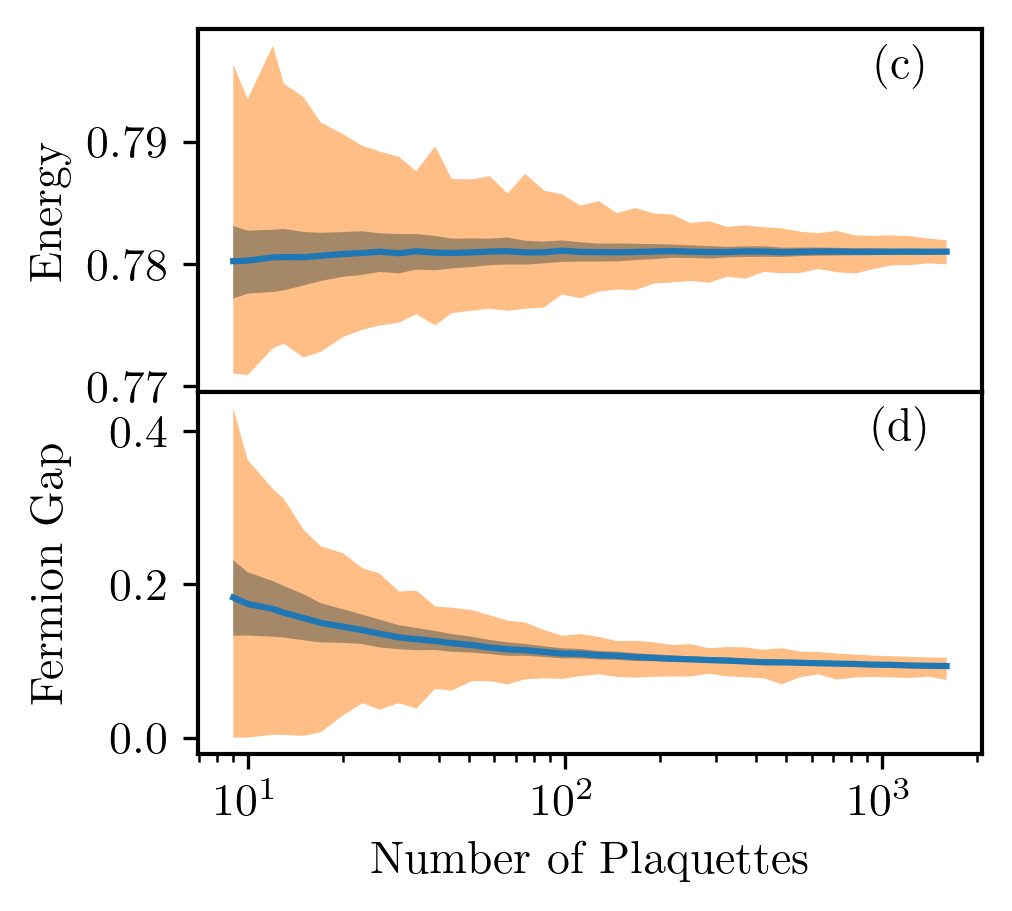

In [4]:
fig = plt.figure(figsize = (3.375,3.2), dpi= 300)

gs = gridspec.GridSpec(nrows = 2, ncols = 1, figure=fig, 
                       height_ratios = (1,1), 
                       wspace = 0.05, hspace = 0.)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
# ax2 = fig.add_subplot(gs[2])


p_max = np.max(all_participations, axis = 0)
p_min = np.min(all_participations, axis = 0)
p_dif = p_max-p_min

g_max = np.max(all_gaps, axis = 0)
g_min = np.min(all_gaps, axis = 0)
g_dif = g_max-g_min

energies_sorted = np.sort(all_energies, axis= 0)
energy_means = np.average(all_energies, axis= 0)

gaps_sorted = np.sort(all_gaps, axis= 0)
gaps_means = np.average(all_gaps, axis= 0)

ax0.set_xscale('log')
ax0.set_ylabel('Energy')
ax1.set_ylabel('Fermion Gap')
ax1.set_xlabel('Number of Plaquettes')

ax1.set_xscale('log')

ax0.text(0.9, 0.9,'(c)',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax0.transAxes)
ax1.text(0.9, 0.9,'(d)',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax1.transAxes)

ax0.plot(plaquette_numbers,energy_means)
ax0.fill_between(plaquette_numbers,energies_sorted[(n_systems)//4,:],energies_sorted[(3*n_systems)//4,:], alpha = 0.8)
ax0.fill_between(plaquette_numbers,energies_sorted[0,:],energies_sorted[-1,:], alpha = 0.5)

ax1.plot(plaquette_numbers,gaps_means)
ax1.fill_between(plaquette_numbers,gaps_sorted[(n_systems)//4,:],gaps_sorted[(3*n_systems)//4,:], alpha = 0.8)
ax1.fill_between(plaquette_numbers,gaps_sorted[0,:],gaps_sorted[-1,:], alpha = 0.5)

# for u in range(n_systems):
#     # ax0.scatter(plaquette_numbers, all_energies[u], alpha = 0.4, s= 0.4)
#     colouring = (all_participations[u] - p_min)/p_dif
#     ax1.scatter(plaquette_numbers, all_gaps[u], c= colouring, vmin = 0, vmax = 1, cmap = 'brg_r', s= 1)
    # ax2.scatter(plaquette_numbers, all_gap_diff[u], c= all_gaps[u], vmin = 0, vmax = 0.18, cmap = 'brg', s=1)
fig.align_ylabels([ax0,ax1])
plt.savefig("e_g_system_size.pdf", format="pdf",bbox_inches = 'tight')
  


In [5]:
plaquette_numbers

array([   9,   10,   12,   13,   15,   17,   20,   23,   26,   30,   34,
         39,   44,   51,   58,   66,   75,   86,   98,  112,  128,  146,
        167,  191,  218,  249,  285,  325,  371,  424,  484,  553,  631,
        721,  824,  941, 1074, 1227, 1401, 1600])